In [1]:
import rasterio
import numpy as np
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.cbook as cbook
from collections import namedtuple
import seaborn as sns
import matplotlib
from numpy import NaN

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import csv

import fiona
import time
from shapely.geometry import mapping, shape
from shapely.geometry import box as shBox
from rasterio import windows as win
from statsmodels.formula.api import ols
import rasterio.plot
from scipy.io import netcdf

# from sklearn import tree
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn import preprocessing
# from sklearn import linear_model
# from sklearn import metrics


import io
from scipy import misc
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [2]:
lc_Address=r'Rasters\EU_LC_100.img'
tc_Address=r'Rasters\tc.img'
st_address=r'Rasters\st.img'
at_address=r'Rasters\airTemp.img'
eaa_raster_address=r'Rasters\EAA.img'
bldgSum_address = r'Rasters\bldgSum.tif'
eaa_vector_address=r'Vectors\RomeUrbanArea.shp'
dem_address= r'Rasters\dem.img'
pet_address= r'Rasters\PET.tif'
alb_address= r'Rasters\albedo.tif'
bu_address = r'Rasters\builtup.tif'
airok_address = r'Rasters\airok.nc'
ndvi_address = r'Rasters\ndvi.tif'
lai_address = r'Rasters\lai.tif'

In [3]:
def findWindow (shapeBound,mainRasterBnd,mainRasterCellSize):
    startRow = int((mainRasterBnd[3] - shapeBound[3])/mainRasterCellSize)
    endRow   = int((shapeBound[3] - shapeBound[1])/mainRasterCellSize)+1+startRow
    startCol = int((shapeBound[0] - mainRasterBnd[0])/mainRasterCellSize)
    endCol   = int((shapeBound[2] - shapeBound[0])/mainRasterCellSize)+1+startCol
    return (startRow,endRow,startCol,endCol)

In [4]:
with rasterio.open(tc_Address) as rst_tc:
            kwds = rst_tc.meta.copy()
            mainRasterBnd=rst_tc.bounds
            cellSize= kwds['transform'][0]

In [5]:
# name field from the eaa vector
nameField='URAU_NAME'
idField='EAA_ID'
countryCode='CNTR_CODE'
kbtuField='KBTU'

In [6]:
for pol in fiona.open(eaa_vector_address):
    #for pol in fiona.open(ecoAcAreasShapefile):
    eaa_name=(pol['properties'][nameField])
    eaa_country=(pol['properties'])[countryCode]
    eaa_id=(pol['properties'][idField])
    # kbtu per sq feet for residential use per year
    kbtu=(pol['properties'][kbtuField])
#     poly_Ycoor=(pol['properties']['Y_coor'])
    poly=(shape(pol['geometry']))
    #msaPoly=[shape(pol['geometry']) for pol in fiona.open(masShapeAddress)]

    with rasterio.open(tc_Address) as rst_tc:
        kwds = rst_tc.meta.copy()
        mainRasterBnd=rst_tc.bounds
        cellSize= kwds['transform'][0]

    polyBound = poly.bounds

    # create a window parameter tuple.   
    winProcessing=findWindow(polyBound,mainRasterBnd,cellSize)
    #(row_start, row_stop), (col_start, col_stop)
    window_use=((winProcessing[0],winProcessing[1]),(winProcessing[2],winProcessing[3]))

    # set the cells that do not have the city id as np.nan. This way we are getting cells insdie the boundary only.
    with rasterio.open(eaa_raster_address) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNoData = (src.meta.copy())['nodata']
        arrayShapes=eaaAr.shape
        eaaAr=eaaAr.flatten()    
        
    with rasterio.open(ndvi_address) as src:
        ndvi=src.read(1, window=window_use)
        ndviNoData = (src.meta.copy())['nodata']
        ndvi=ndvi.flatten() 
        
    with rasterio.open(lai_address) as src:
        lai=src.read(1, window=window_use)
        laiNoData = (src.meta.copy())['nodata']
        lai=lai.flatten() 
        
        
    with rasterio.open(alb_address) as src:
        alb=src.read(1, window=window_use)
        albNoData = (src.meta.copy())['nodata']
        arrayShapes=alb.shape
        alb=alb.flatten() 
    
        
    with rasterio.open(pet_address) as src:
        pet=src.read(1, window=window_use)
        petNoData = (src.meta.copy())['nodata']
        pet=pet.astype('float')
        pet=pet.flatten()
        
    with rasterio.open(bu_address) as src:
        bu=src.read(1, window=window_use)
        buNoData = (src.meta.copy())['nodata']
        bu=bu.astype('float')
        bu=bu.flatten()
        
    with rasterio.open(tc_Address) as rst_tc:
        tc_ar=rst_tc.read(1, window=window_use)
        tcNoData = (rst_tc.meta.copy())['nodata']
        tc_ar=tc_ar.astype('float')
        #nlcd_tc_win_ar[eaaAr!=eaa_id]=np.nan
        tc_ar=tc_ar.flatten()
        kwds = rst_tc.meta.copy()
        #print ('got the nlcd-tc layer')

    with rasterio.open(lc_Address) as src:
        lc_ar=src.read(1, window=window_use)
        lcNoData = (src.meta.copy())['nodata']
        lc_ar=lc_ar.astype('float')
        #nlcd_lc[eaaAr!=eaa_id]=np.nan
        lc_ar=lc_ar.flatten()
        #print('got the nlcd-lc layer')

    with rasterio.open(st_address) as src:
        st=src.read(1, window=window_use)
        stNoData = (src.meta.copy())['nodata']
        st=st.astype('float')
        st=st.flatten()
        
  #I substituded "at" with "air" since it was causing issues as a predefined word in python      
    with rasterio.open(at_address) as src:
        air=src.read(1, window=window_use)
        airNoData = (src.meta.copy())['nodata']
        air=air.astype('float')
        air=air.flatten()
        
    with rasterio.open(dem_address) as src:
        dem=src.read(1, window=window_use)
        demNoData = (src.meta.copy())['nodata']
        dem=dem.astype('float')
        dem=dem.flatten()
    
    with rasterio.open(bldgSum_address) as src:
        bldgSum = src.read(1,window=window_use)
        bldgNodata = (src.meta.copy())['nodata']
        bldgSum = bldgSum.astype('float')
        bldgSum = bldgSum.flatten()
        
    allArrays=np.dstack((tc_ar,lc_ar,st,air,eaaAr,bldgSum,dem,pet,bu,alb,ndvi,lai))
    allArrays=allArrays[0,:,:]

    df=pd.DataFrame(allArrays,columns=['tc','lc','st','air','eaaAr','bldgSum','elevation','pet','bu','alb','ndvi','lai'])

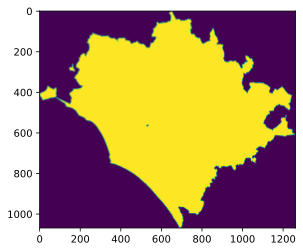

In [12]:
 with rasterio.open(eaa_raster_address) as src:
        dem = src.read(1,window=window_use)
        plt.imshow(dem)

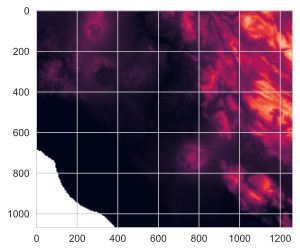

In [164]:
ar_test = np.array(df.elevation)
plt.imshow(ar_test.reshape(kwds['height'],kwds['width']))

In [60]:
df.head()

,tc,lc,st,air,eaaAr,bldgSum,elevation,pet,bu
0,63.0,311.0,3726.0,2986.0,0.0,0.0,175.0,203.0,0.0
1,74.0,311.0,3741.0,2986.0,0.0,0.0,180.0,203.0,0.0
2,74.0,311.0,3741.0,2986.0,0.0,0.0,181.0,203.0,0.0
3,74.0,311.0,3754.0,2985.0,0.0,0.0,180.0,203.0,0.0
4,69.0,311.0,3796.0,2985.0,0.0,0.0,180.0,203.0,0.0


In [7]:
#let's change nodata to np.nan
df.loc[df['air']==airNoData, 'air'] = np.NaN
df.loc[df['st']==stNoData, 'st'] = np.NaN
df.loc[df['lc']==lcNoData, 'lc'] = np.NaN
df.loc[df['tc']==tcNoData, 'tc'] = np.NaN
df.loc[df['eaaAr']==eaaNoData, 'eaaAr'] = np.NaN
df.loc[df['bldgSum']==bldgNodata, 'bldgSum'] = np.NaN
df.loc[df['elevation']==demNoData, 'elevation'] = np.NaN
df.loc[df['pet']==petNoData, 'pet'] = np.NaN
df.loc[df['st']<10, 'st'] = np.NaN
df.loc[df['bu']==buNoData, 'bu'] = np.NaN
df.loc[df['alb']==buNoData, 'alb'] = np.NaN
df.loc[df['ndvi']==buNoData, 'ndvi'] = np.NaN

In [8]:
#now let's set to np.nan all the data outside the area of interest, so all the rasters will be equal when performing the regressions
df.loc[df['eaaAr']!= 1, 'air'] = np.NaN
df.loc[df['eaaAr']!= 1, 'st'] = np.NaN
df.loc[df['eaaAr']!= 1, 'lc'] = np.NaN
df.loc[df['eaaAr']!= 1, 'tc'] = np.NaN
df.loc[df['eaaAr']!= 1, 'air'] = np.NaN
df.loc[df['eaaAr']!= 1, 'bldgSum'] = np.NaN
df.loc[df['eaaAr']!= 1, 'elevation'] = np.NaN
df.loc[df['eaaAr']!= 1, 'pet'] = np.NaN
df.loc[df['eaaAr']!= 1, 'bu'] = np.NaN
df.loc[df['eaaAr']!= 1, 'alb'] = np.NaN
df.loc[df['eaaAr']!= 1, 'ndvi'] = np.NaN

In [110]:
np.NaN in df['eaaAr'].values
df['air'][df.air == np.NaN], np.NaN in df.air.values

(Series([], Name: air, dtype: float64), False)

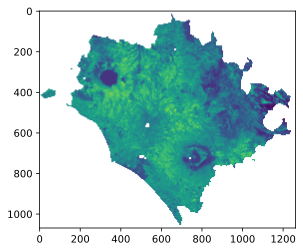

In [15]:
ar_test = np.array(df.st)
plt.imshow(ar_test.reshape(kwds['height'],kwds['width']))

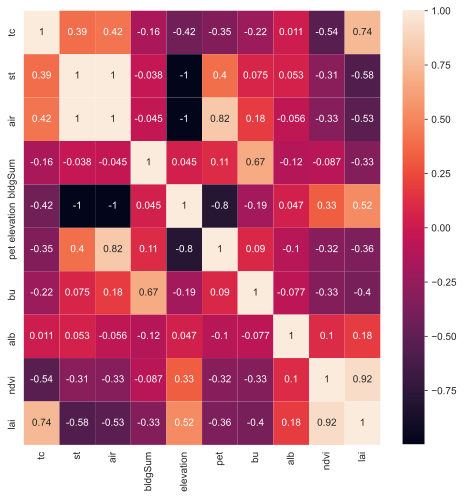

In [28]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.heatmap(((df[['tc','st','air','bldgSum','elevation','pet','bu','alb','ndvi','lai']]).corr()), annot=True)

In [9]:
df['st']=df['st']/100;
df['air']=df['air']/100;
df['bldgSum']=df['bldgSum']/100;
df['pet']=df['pet']/100

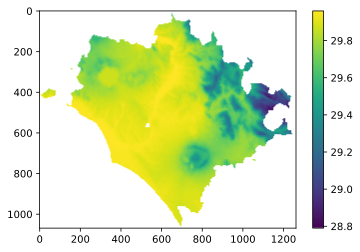

In [10]:
ar_test = np.array(df.air)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

## tc + e1 ---> st + e2 ----> at + f(e1,e2)

In [11]:
#modeling st from tc. Adding more variables (elevation, distance from vwater bodies, albedo) should improve the fit, but a traceback occurs when we run "predict_air_tc0"
df['tc0']=0
features_st_model = ['tc','elevation','bu']
depVar_st_model = df['st']
indepVar_st_model = sm.add_constant(df[features_st_model],has_constant='add')
st_model = sm.OLS(depVar_st_model, indepVar_st_model,missing='drop')
results_st_model = st_model.fit()
print(results_st_model.summary())

# now lets record the estimated ST
predict_st = results_st_model.get_prediction(indepVar_st_model)
predict_st = predict_st.summary_frame(alpha=0.05)
df['estimated_st'] = predict_st['mean']

                            OLS Regression Results                            
Dep. Variable:                     st   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                 2.930e+05
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        10:49:23   Log-Likelihood:            -1.5335e+06
No. Observations:              615389   AIC:                         3.067e+06
Df Residuals:                  615385   BIC:                         3.067e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.5620      0.006   7683.707      0.0

In [12]:
# now let's see what whould be ST wit TC0
features_st_model_tc0 = ['tc0','elevation','bu']
indepVar_st_model_tc0 = sm.add_constant(df[features_st_model_tc0],has_constant='add')
predict_st_tc0 = results_st_model.get_prediction(indepVar_st_model_tc0)
predict_st_tc0 = predict_st_tc0.summary_frame(alpha=0.05)

# create a col that shows the estiamted st when tc is 0
df['estimated_st_tc0'] = predict_st_tc0['mean']

# now let's build a model that uses st as the independent variable and estimates air temperature
features_at_model = ['st','ndvi','bu']
depVar_air_model = df['air']
indepVar_air_model = sm.add_constant(df[features_at_model],has_constant='add')
at_model = sm.OLS(depVar_air_model,indepVar_air_model,missing='drop')
results_at_model = at_model.fit()
print(results_at_model.summary())

# now let's estiamte air temperature with this model
predict_at = results_at_model.get_prediction(indepVar_air_model)
predict_at = predict_at.summary_frame(alpha=0.05)
df['estimated_air'] = predict_at['mean']

df['error_st']= ((predict_st['obs_ci_upper']-predict_st['obs_ci_lower'])/2)
#R squared is very low

                            OLS Regression Results                            
Dep. Variable:                    air   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                 1.434e+05
Date:                Sun, 31 May 2020   Prob (F-statistic):               0.00
Time:                        10:49:25   Log-Likelihood:             2.5034e+05
No. Observations:              615389   AIC:                        -5.007e+05
Df Residuals:                  615385   BIC:                        -5.006e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9890      0.003   9894.670      0.0

In [69]:
# now let's estiamte air temperature from esitmated_st_tc0
features_at_model_tc0 = ['estimated_st_tc0','ndvi','bu']
indepVar_air_model_tc0 = sm.add_constant(df[features_at_model_tc0],has_constant='add')

#why do we get the prediction for air temp from the st model? and why using st_tc0 as indep var?
predict_air_tc0 = results_at_model.get_prediction(indepVar_air_model_tc0)
predict_air_tc0 = predict_air_tc0.summary_frame(alpha=0.05)
# create a col that shows the estiamted st when tc is 0
df['estimated_at_tc0'] = predict_air_tc0['mean']

df['error_at'] = (predict_at['obs_ci_upper']-predict_at['obs_ci_lower'])/2
# now let's calculate cooling
df['coolingst'] = df['estimated_st_tc0']-df['estimated_st']
df['cooling'] = df['estimated_at_tc0']-df['estimated_air']
df.sample(10)

,tc,lc,st,air,eaaAr,bldgSum,elevation,pet,bu,alb,...,lai,tc0,estimated_st,estimated_st_tc0,estimated_air,error_st,estimated_at_tc0,error_at,coolingst,cooling
1023190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.754133,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1214765,42.0,242.0,38.49,29.89,1.0,0.00,59.0,1.98,0.0,0.2064,...,NaN,0,41.361256,44.274680,29.778720,5.731174,29.905796,0.315753,2.913424,0.127076
416034,44.0,243.0,39.62,29.43,1.0,687.85,775.0,1.97,0.0,0.2094,...,5.944964,0,37.735263,40.787421,29.754582,5.731180,29.780227,0.315751,3.052158,0.025646
1159652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415827,0.0,211.0,49.55,29.95,1.0,0.00,37.0,2.06,0.0,0.1950,...,2.654267,0,44.381830,44.381830,29.997687,5.731174,29.884155,0.315752,0.000000,-0.113533
614040,0.0,211.0,45.10,29.90,1.0,0.00,102.0,2.06,0.0,0.1850,...,2.918716,0,44.065250,44.065250,29.901831,5.731173,29.879100,0.315751,0.000000,-0.022731
1282833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1135829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
583246,0.0,242.0,42.84,29.95,1.0,0.00,26.0,2.06,0.0,0.2070,...,2.907468,0,44.435406,44.435406,29.855000,5.731174,29.890047,0.315751,0.000000,0.035047
359553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df.estimated_air.min(), df.estimated_air.max()

(29.390427031583453, 30.143223152985748)

In [93]:
df.air.min(), df.air.max()

(28.79, 29.96)

In [123]:
#checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = results_st_model.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

[1.7389616669343806, 1.0000000000000384]

In [18]:
np.array(vif).mean()

1.6677176150596218

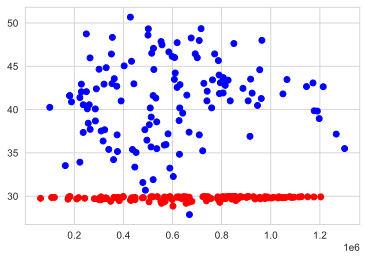

43.54592862760175

In [186]:
plt.plot(df['air'].sample(250),marker='o',color='red',linestyle='None')
plt.plot(df['st'].sample(250),marker='o',color='blue',linestyle='None')
plt.show()

df.estimated_st.max()

In [189]:
df.estimated_air.min(), df.estimated_air.max()

(29.56633531360795, 29.85811129041854)

In [57]:
dfok=df[(df['cooling']>0)]

In [58]:
dfok['cooling'].max()

0.2915284076554734

In [128]:
df['propagated_error']=np.sqrt((np.square(df['error_st']/df['estimated_st']))*2 + (np.square(df['error_at']/df['estimated_air']))*2)
#error of air temperature estimated

In [133]:
df['propagated_error'].mean()

0.214793948512632

(array([73., 45., 38., 31., 26., 18.,  9.,  5.,  2.,  3.]),
 array([3.26034264e-05, 4.06095399e-02, 8.11864763e-02, 1.21763413e-01,
        1.62340349e-01, 2.02917286e-01, 2.43494222e-01, 2.84071159e-01,
        3.24648095e-01, 3.65225031e-01, 4.05801968e-01]),
 <a list of 10 Patch objects>)

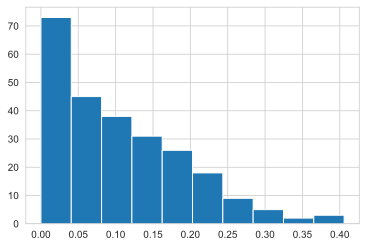

In [56]:
plt.hist(dfok['cooling'].sample(250))

In [52]:
df_dropped['elevation'].mean(),df_dropped['elevation'].sem()

(295.3352027785791, 0.4035050528332758)

In [29]:
df_dropped= df.dropna()
dftc=df_dropped[(df_dropped['tc']>10)]
dftc.head()

,tc,lc,st,air,eaaAr,bldgSum,elevation,pet,tc0,estimated_st,estimated_st_tc0,estimated_air,error_st,estimated_at_tc0,error_at,cooling,propagated_error
649,92.0,311.0,33.16,29.56,1.0,0.0,670.0,2.00,0,35.489210,43.545929,29.552825,6.324160,39.73248,0.326916,10.179655,0.252497
650,96.0,311.0,33.49,29.47,1.0,0.0,661.0,1.98,0,35.138918,43.545929,29.562062,6.324162,39.73248,0.326916,10.170417,0.255005
651,95.0,311.0,33.31,29.47,1.0,0.0,649.0,1.98,0,35.226491,43.545929,29.557024,6.324161,39.73248,0.326916,10.175456,0.254373
1910,88.0,311.0,32.85,29.56,1.0,0.0,672.0,2.00,0,35.839502,43.545929,29.544148,6.324158,39.73248,0.326916,10.188332,0.250039
1911,94.0,311.0,33.33,29.56,1.0,0.0,658.0,2.00,0,35.314064,43.545929,29.557584,6.324161,39.73248,0.326916,10.174896,0.253745


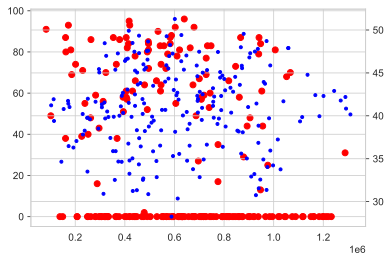

In [94]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(df['tc'].sample(500), marker='o',color='red',linestyle='None')
ax2.plot(df['st'].sample(500),  marker='.',color='blue',linestyle='None')

plt.show()

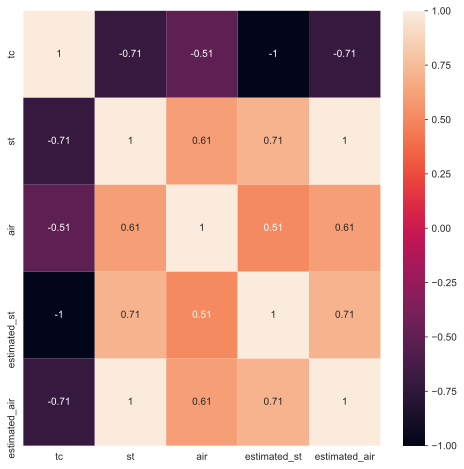

In [31]:
sns.set_style("whitegrid")
plt.figure(figsize=(8,8))
sns.heatmap(((df[['tc','st','air','estimated_st','estimated_air']]).corr()), annot=True)

In [171]:
df['coolingst'] = df['estimated_st_tc0']-df['estimated_st']
df['coolingst'].mean()

2.1146058834204267

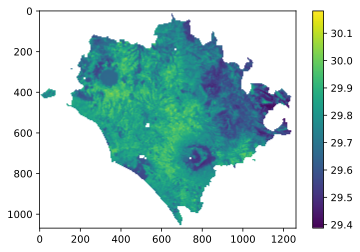

In [71]:
ar_test = np.array(df.estimated_air)
fig, ax = plt.subplots()
img = ax.imshow(ar_test.reshape(kwds['height'],kwds['width']))
fig.colorbar(img, ax=ax)

In [132]:
#writing the rasters

with rasterio.open(eaa_raster_address) as src:
        eaaAr=src.read(1, window=window_use)
        eaaNoData = (src.meta.copy())['nodata']
        arrayShapes=eaaAr.shape
        profile=src.profile
        
cooling = np.array(df.cooling)
cooling=cooling.reshape(kwds['height'],kwds['width'])

outputFolder=r''

coolingtowriteraster     = outputFolder +r'C:\Users\nauti\EU_JRC_Urban_Heat_Mitigation\Rasters\cooling.img'

ardatatype='float64'

cooling= (cooling).astype(ardatatype)
profile['dtype']=ardatatype

with rasterio.open(coolingtowriteraster, 'w', **profile) as output:
    output.write_band(1,cooling)

In [133]:
est_st=np.array(df.estimated_st)
est_st=est_st.reshape(kwds['height'],kwds['width'])

outputFolder=r''

est_sttowriteraster     = outputFolder +r'C:\Users\nauti\EU_JRC_Urban_Heat_Mitigation\Rasters\estimated_st.img'

ardatatype='float64'

est_st= (est_st).astype(ardatatype)
profile['dtype']=ardatatype

with rasterio.open(est_sttowriteraster, 'w', **profile) as output:
    output.write_band(1,est_st)

In [134]:
est_at=np.array(df.estimated_air)
est_at=est_at.reshape(kwds['height'],kwds['width'])

outputFolder=r''

est_attowriteraster     = outputFolder +r'C:\Users\nauti\EU_JRC_Urban_Heat_Mitigation\Rasters\estimated_at.img'

ardatatype='float64'

est_at= (est_at).astype(ardatatype)
profile['dtype']=ardatatype

with rasterio.open(est_attowriteraster, 'w', **profile) as output:
    output.write_band(1,est_at)